## 文本生成 - 藏头诗

### 1. 导入依赖库

In [1]:
import os
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

### 2. 准备数据

#### 2.1 加载原始数据

In [2]:
# 数据集路径
poetry_file ='poetry.txt'  
# 导入诗集  
poetrys = []  
with open(poetry_file, "r" , encoding = 'UTF-8') as f:  
    for line in f:  
        try:  
            #line = line.decode('UTF-8')
            line = line.strip(u'\n')
            title, content = line.strip(u' ').split(u':')  
            content = content.replace(u' ',u'')  
            if u'_' in content or u'(' in content or u'（' in content or u'《' in content or u'[' in content:  
                continue  
            if len(content) < 5 or len(content) > 79:  
                continue  
            content = u'[' + content + u']'  
            poetrys.append(content)  
        except Exception as e:   
            pass  

# 按诗的字数排序  
poetrys = sorted(poetrys,key=lambda line: len(line))  
print('唐诗总数: ', len(poetrys)) 
print('\n'.join(poetrys[:10]))

唐诗总数:  34646
[长宜子孙。]
[李下无蹊。]
[罗钳吉网。]
[常杂鲍帖。]
[扬一益二。]
[枫落吴江冷。]
[人生分外愁。]
[木末上明星。]
[犬熟护邻房。]
[兔子上金床。]


#### 2.2 构建词汇表

In [3]:
vocab = sorted(set([char for poe in poetrys for char in poe]))
vocab.insert(0, "[PAD]")
print ('词汇表长度：{}'.format(len(vocab)))
char2int = {c:i for i, c in enumerate(vocab)}
int2char = np.array(vocab)
print('字符-id 映射：')
for char,_ in zip(char2int, range(20)):
    print(' {:4s}: {:3d},'.format(repr(char), char2int[char]))
print('id-字符映射：')    
print('id 为 10 对应的字符为：{}'.format(int2char[10]))

词汇表长度：6110
字符-id 映射：
 '[PAD]':   0,
 '2' :   1,
 'F' :   2,
 '[' :   3,
 ']' :   4,
 'p' :   5,
 'ē' :   6,
 'ń' :   7,
 '□' :   8,
 '、' :   9,
 '。' :  10,
 '】' :  11,
 '一' :  12,
 '丁' :  13,
 '七' :  14,
 '万' :  15,
 '丈' :  16,
 '三' :  17,
 '上' :  18,
 '下' :  19,
id-字符映射：
id 为 10 对应的字符为：。


In [4]:
poetrys_as_int = [[char2int[char] for char in poetry] for poetry in poetrys]
print ('{}\n mapped to integers:\n {}'.format(repr(poetrys[0]), poetrys_as_int[0]))

'[长宜子孙。]'
 mapped to integers:
 [3, 5459, 1108, 1070, 1076, 10, 4]


#### 2.3 划分训练、验证集

In [5]:
poetrys_shuffle = shuffle(poetrys_as_int, random_state=0)
train_inputs = poetrys_shuffle[:28000]
valid_inputs = poetrys_shuffle[28000:]

#### 2.4 填充、转换成tf.data.Dataset

In [6]:
max_train = max([len(seq) for seq in train_inputs])
print('max length: {}'.format(max_train))
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, maxlen=max_train, padding='post', value=char2int['[PAD]'])
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_inputs, maxlen=max_train, padding='post', value=char2int['[PAD]'])

train_ds = tf.data.Dataset.from_tensor_slices(train_padded)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_padded)

max length: 81


#### 2.5 输入、输出切分

In [7]:
def split_input_target(seq):
    inputs = seq[:-1]
    targets = seq[1:]
    return inputs, targets

train_ds = train_ds.map(split_input_target).shuffle(buffer_size=10000).batch(batch_size=64, drop_remainder=True)
valid_ds = valid_ds.map(split_input_target).shuffle(buffer_size=10000).batch(batch_size=64, drop_remainder=True)

### 3. 模型训练

#### 3.1 定义配置参数

In [8]:
embedding_dim = 256
rnn_units = 1024
batch_size = 64
vocab_size = len(vocab)

#### 3.2 定义模型结构

In [9]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [10]:
model = build_model(vocab_size = vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           1564160   
                                                                 
 dropout (Dropout)           (64, None, 256)           0         
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dropout_1 (Dropout)         (64, None, 1024)          0         
                                                                 
 lstm_1 (LSTM)               (64, None, 1024)          8392704   
                                                                 
 dropout_2 (Dropout)         (64, None, 1024)          0         
                                                                 
 dense (Dense)               (64, None, 6110)          6

#### 3.3 训练前测试

In [12]:
for input_example_batch, target_example_batch in train_ds.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "respectively: batch_size, sequence_length, vocab_size")

(64, 80, 6110) respectively: batch_size, sequence_length, vocab_size


In [13]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Input: \n", repr("".join(int2char[input_example_batch[0]])))
print()
print("Predictions: \n", repr("".join(int2char[sampled_indices ])))

Input: 
 '[结宇依青嶂，开轩对绿畴。树交花两色，溪合水同流。竹径春来扫，兰尊夜不收。逍遥自得意，鼓腹醉中游。][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

Predictions: 
 '獯籝靖戺贴辕罂瞳逼恤蜦裁音倩曰怆祥战牂缎还携阜槐倩莨喟爪纨迒劲矰预躬猿靓漭踞买堰褧檠铜髑闉瘵迦涴咀岳嘿扆泛踬铪述旃拓坤铗斯综菱挂鳖煨痾诈患浪烟疼怵谡瀔累剪佑仰羑'


In [14]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
def accuracy(labels, logits):
    return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
example_batch_acc  = accuracy(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Loss:      ", example_batch_loss.numpy().mean())
print("Accuracy:      ", example_batch_acc.numpy().mean())

Prediction shape:  (64, 80, 6110)  # (batch_size, sequence_length, vocab_size)
Loss:       8.718245
Accuracy:       0.0001953125


#### 3.4 启动训练

In [15]:
# 编译优化器及损失函数
optimizer = tf.keras.optimizers.Adam() 
model.compile(optimizer=optimizer, loss=loss)

In [16]:
# 定义 early stop 回调函数
patience = 10
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [17]:
# 定义 checkpoint 回调函数
checkpoint_prefix = './checkpoints/poetry_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

In [18]:
history = model.fit(train_ds, epochs=50, callbacks=[checkpoint_callback, early_stop] , validation_data=valid_ds)

Epoch 1/50
437/437 [==============================] - 84s 183ms/step - loss: 3.8863 - val_loss: 3.5090
Epoch 2/50
437/437 [==============================] - 82s 187ms/step - loss: 3.4172 - val_loss: 3.2947
Epoch 3/50
437/437 [==============================] - 87s 199ms/step - loss: 3.2411 - val_loss: 3.1808
Epoch 4/50
437/437 [==============================] - 89s 202ms/step - loss: 3.1354 - val_loss: 3.0894
Epoch 5/50
437/437 [==============================] - 91s 208ms/step - loss: 3.0353 - val_loss: 3.0084
Epoch 6/50
437/437 [==============================] - 100s 228ms/step - loss: 2.9481 - val_loss: 2.9430
Epoch 7/50
437/437 [==============================] - 97s 220ms/step - loss: 2.8718 - val_loss: 2.8903
Epoch 8/50
437/437 [==============================] - 98s 223ms/step - loss: 2.8055 - val_loss: 2.8515
Epoch 9/50
437/437 [==============================] - 97s 221ms/step - loss: 2.7458 - val_loss: 2.8173
Epoch 10/50
437/437 [==============================] - 99s 226ms/step - 

#### 3.5 可视化损失变化

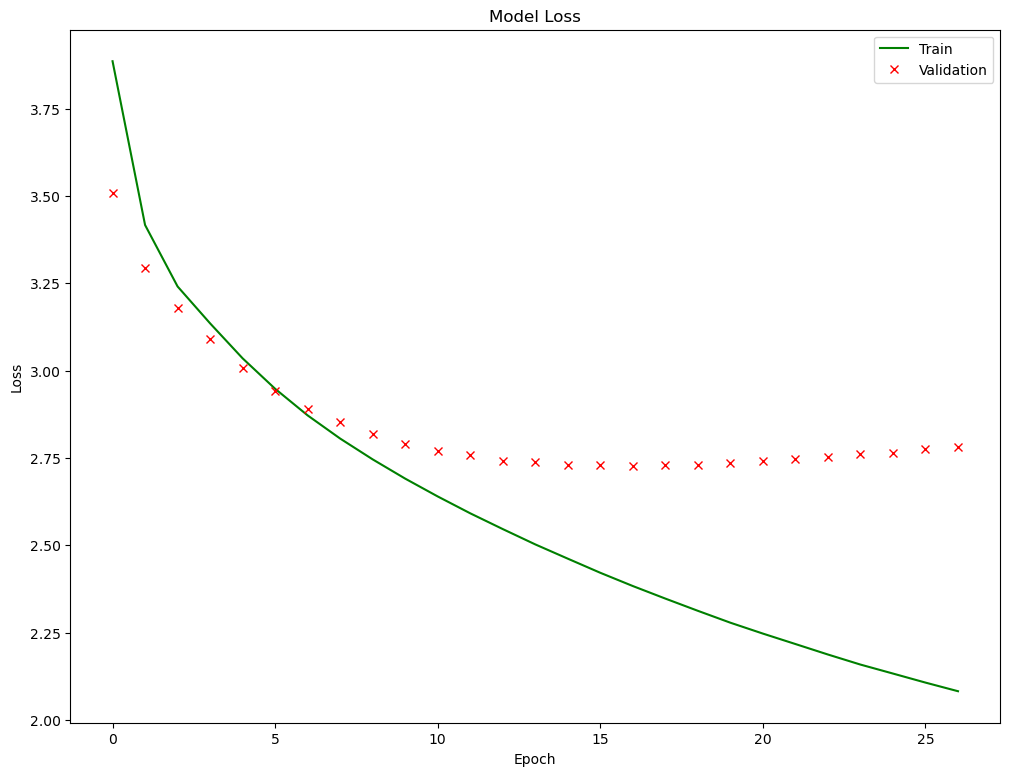

In [19]:
plt.figure(figsize=(12,9))
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'rx') #use if have val data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.legend(['Train', 'Validation'], loc='upper right') #use if have val data
plt.show()

#### 3.6 训练后测试

In [20]:
for input_example_batch, target_example_batch in train_ds.take(1):
    example_batch_predictions = model(input_example_batch)
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Input: \n", repr("".join(int2char[input_example_batch[0]])))
print()
print("Predictions: \n", repr("".join(int2char[sampled_indices ])))

Input: 
 '[绮陌彤彤花照尘，王门侯邸尽朱轮。城南旧有山村路，欲向云霞觅主人。][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'

Predictions: 
 '古霞不襜玉吐旗，明王开女昔琼轮。蓬荒红隐才河老，上别蓬山上世人。][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'


### 4. 推理测试

#### 4.1 离线加载模型

In [21]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(checkpoint_prefix)  # 指定模型
model.build(tf.TensorShape([1, None]))

#### 4.2 定义推理测试函数

In [22]:
def generate_poetry(model, head_string):
    print("藏头诗生成中...., {}".format(head_string))
    poem = ""
    for head in head_string:
        if head not in char2int:
            print("抱歉，不能生成以{}开头的诗".format(head))
            return
        
        sentence = head
        max_sent_len = 20
        
        input_eval = [char2int[s] for s in '[' + head]
        input_eval = tf.expand_dims(input_eval, 0)
        
        model.reset_states()
        for i in range(max_sent_len):
            predictions = model(input_eval)
            predictions = tf.squeeze(predictions, 0)
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
            char_generated = int2char[predicted_id]
            if char_generated == '。':
                break
            input_eval = tf.expand_dims([predicted_id], 0)
            sentence += char_generated
    
        poem += '\n' + sentence
                
    return poem          

#### 4.3 测试藏头诗生成

In [26]:
poetry = generate_poetry(model, "自然语言处理")
print(poetry)

藏头诗生成中...., 自然语言处理

自两簪白了，斋栖客事同禅
然顾岐路，春洲江上雪前
语乐恐光辉
言长吉彩难，祥景无容礼德馨
处向岁边江南阔
理念是非神
